# Shor's algorithm in Qiskit

Disclaimer: some bugs may occur in this notebook and algorithm's implementations. If so, please report them on GitHub. Thanks :)

## Preparations

In [1]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram

In [2]:
import sys
import logging
import random

sys.path.append('master-thesis')

logging.basicConfig(level=logging.INFO)

for handler in logging.getLogger().handlers:
    handler.setLevel(logging.WARNING)

logger = logging.getLogger('implementations.shor')
logger.setLevel(logging.INFO)

if len(logger.handlers) == 0:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(name)s: %(message)s'))
    handler.addFilter(logging.Filter('implementations.shor'))
    logger.addHandler(handler)

Select numbers to test.

In [3]:
# N = 15, 21; also 35, 55 (for these, simulation will be long locally, up to 6 minutes)
N = 55

# 1 < a < N and gcd(a, N) = 1
a = 4

## Classical calculations

Compute classically reminders of `a^x mod N` for `x = 1, ..., 20`. Present results on graph, observe the period. For modular power, see https://docs.python.org/3.8/library/functions.html#pow

In [4]:
exponents = list(range(0, 101))
values = []

for i in exponents:
    value = pow(a, i, mod=N)
    values.append(value)

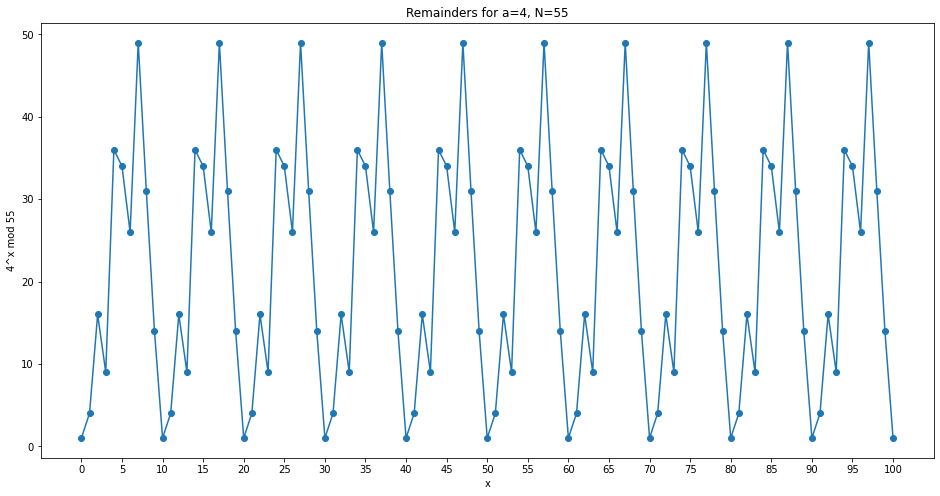

In [5]:
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(range(0, 101, 5))
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

## Operation `a^x mod N` in Qiskit

Import gate for modular exponentiation. You can also use other implementations (mind the number of ancillary qubits).

In [6]:
from gates.mix.modular_exponentiation import modular_exponentiation_gate  # (n + 1 ancilla)

# from gates.takahashi.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla)

# from gates.beauregard.modular_exponentiation import modular_exponentiation_gate # (n + 2 ancilla)

# from gates.haner.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla, big size of circuit!)

Count width `n` of `N`.

In [7]:
n = N.bit_length()
print(n)

6


Create registers and circuit.

In [8]:
# input register
x_qreg = QuantumRegister(2 * n, name='x')

# output register, must contain 1
y_qreg = QuantumRegister(n, name='y')

In [9]:
# ancillary register; change the size according to selected implementation
ancillary_register_size = n + 1
aux_qreg = QuantumRegister(ancillary_register_size, name='aux')

In [10]:
circuit = QuantumCircuit(x_qreg, y_qreg, aux_qreg)

In [11]:
# prepare input register
circuit.h(x_qreg)

# prepare output register
circuit.x(y_qreg[0])

In [12]:
# append gate
gate = modular_exponentiation_gate(a, N, n)
circuit.append(gate, circuit.qubits)

In [13]:
# measure output register
y_creg = ClassicalRegister(n, name='yValue')
circuit.add_register(y_creg)
circuit.measure(y_qreg, y_creg)

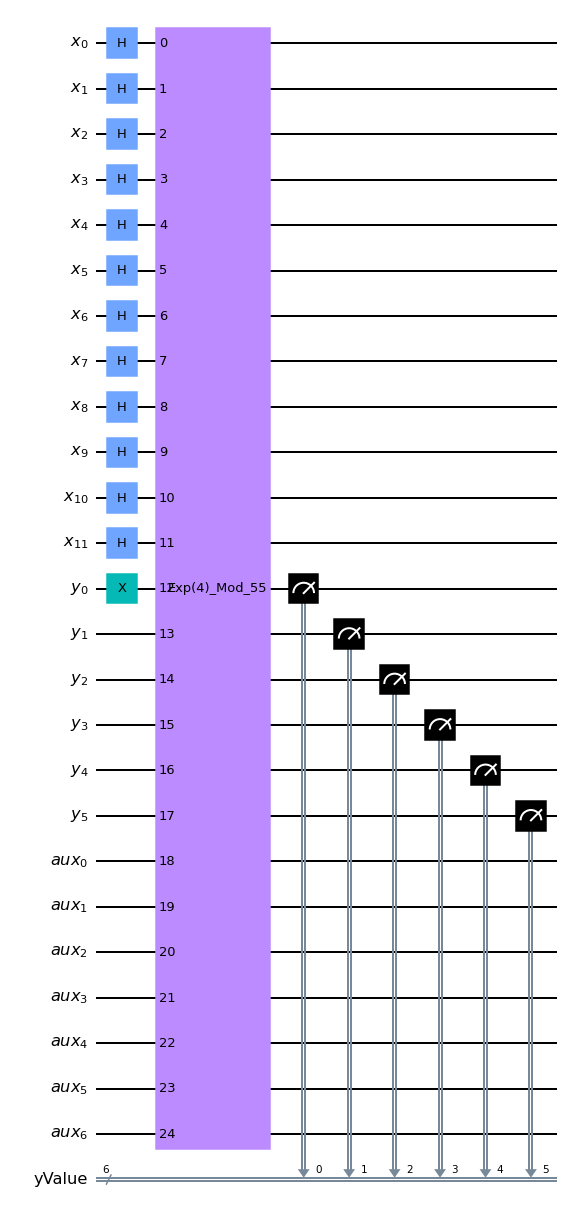

In [14]:
circuit.draw(output='mpl', fold=-1)

Run circuit. Usage of IBMQ simulator for `n > 5` is suggested.

In [15]:
def get_quantum_instance(cloud):
    if cloud:
        from qiskit import IBMQ
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_qasm_simulator')
    else:
        from qiskit import Aer
        backend = Aer.get_backend('qasm_simulator')

    return QuantumInstance(backend)

In [16]:
instance = get_quantum_instance(cloud=True)
instance.set_config(shots=64)
exponentiation_result = instance.execute(circuit)

__init__.discover_credentials:INFO:2022-05-14 21:20:42,825: Using credentials from qiskitrc
account.job_final_status:INFO:2022-05-14 21:21:13,547: Error checking job status using websocket, retrying using HTTP: 'Failed to authenticate against the server: Traceback (most recent call last):\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_app.py", line 327, in run_forever\n    self.sock.connect(\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_core.py", line 248, in connect\n    self.handshake_response = handshake(self.sock, url, *addrs, **options)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 57, in handshake\n    status, resp = _get_resp_headers(sock)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 148, in _get_resp_headers\n    raise WebSocketBadStatusException("Handshake status %d %s", status, status_messag

Draw histogram. Compare results with classical calculations.

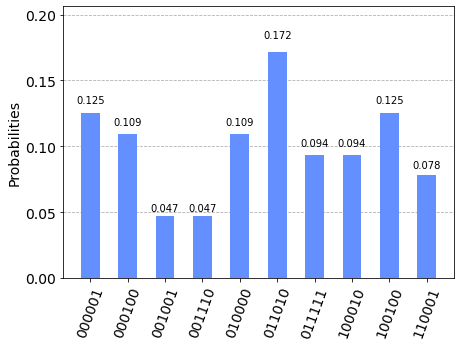

In [17]:
counts = exponentiation_result.get_counts(circuit)
plot_histogram(counts)

Let's try observe period.

In [18]:
# clone circuit
circuit2 = circuit.copy()

# measure input register
x_creg = ClassicalRegister(2 * n, name='xValue')
circuit2.add_register(x_creg)
circuit2.measure(x_qreg, x_creg)

In [19]:
instance.set_config(shots=128)
exponentiation_and_exponent_result = instance.execute(circuit2)

account.job_final_status:INFO:2022-05-14 21:25:46,370: Error checking job status using websocket, retrying using HTTP: 'Failed to authenticate against the server: Traceback (most recent call last):\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_app.py", line 327, in run_forever\n    self.sock.connect(\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_core.py", line 248, in connect\n    self.handshake_response = handshake(self.sock, url, *addrs, **options)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 57, in handshake\n    status, resp = _get_resp_headers(sock)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 148, in _get_resp_headers\n    raise WebSocketBadStatusException("Handshake status %d %s", status, status_message, resp_headers)\nwebsocket._exceptions.WebSocketBadStatusException: Handshake status 502 Ba

In [20]:
counts = exponentiation_and_exponent_result.get_counts(circuit2)
values_map = {}
for measurement in counts.keys():
    x, y = [int(value, base=2) for value in measurement.split(' ')]
    values = values_map.get(y, [])
    values.append(x)
    values_map[y] = values

Print measured `x` values for each exponentiation result.
You should observe that values differs from each other by constant - period `r`. (precisely, only part of them
in different runs will - think why!)

In [21]:
for y, x_values in values_map.items():
    print(y)
    print(sorted(x_values))
    print()

26
[736, 1036, 1166, 1526, 2176, 2576, 2866, 3146, 3756, 3836]

16
[392, 632, 682, 722, 852, 902, 1042, 1972, 2402, 2452, 3242, 3582]

34
[85, 535, 1045, 1145, 1505, 1525, 1595, 2095, 2115, 2455, 2655, 2945, 3085, 3295, 3375, 3625, 3665, 3865]

31
[38, 288, 578, 828, 1008, 1158, 1298, 1808, 2828, 3618, 3698, 3808]

4
[101, 311, 1191, 1331, 1701, 2711, 3091, 3111, 3261, 3611]

14
[529, 879, 899, 1259, 1329, 1439, 1699, 1849, 1969, 2399, 2649, 3009, 3049, 3549, 3909]

1
[220, 360, 440, 690, 1290, 1380, 1420, 1670, 2620, 2980, 3390, 3530, 3610, 3650, 3790, 4030]

49
[127, 477, 517, 937, 967, 1367, 1647, 1687, 1917, 2427, 2717, 2947, 3737, 4017]

9
[343, 603, 1403, 1633, 2233, 2283, 2333, 3343, 3583, 3683, 3833]

36
[224, 254, 684, 974, 1754, 2944, 3424, 3734, 3754, 4064]



## Finding period / order in Qiskit

Import Shor's algorithm implementation.
Similarly to modular exponentiation gate, you can test different implementations.

In [22]:
from implementations.mix import MixShor as Shor

# from implementations.takahashi import TakahashiShor as Shor

# from implementations.beauregard import BeauregardShor as Shor

# from implementations.haner import HanerShor as Shor # (big size of circuit!)

For usage, class instance have to be created.

In [23]:
instance = get_quantum_instance(cloud=True)
instance.set_config(shots=64)

# create instance of class
shor = Shor(instance)

__init__.discover_credentials:INFO:2022-05-14 21:29:51,497: Using credentials from qiskitrc
ibmqfactory.load_account:WARNING:2022-05-14 21:29:52,085: Credentials are already in use. The existing account in the session will be replaced.


Observe 3 parts of algorithm.

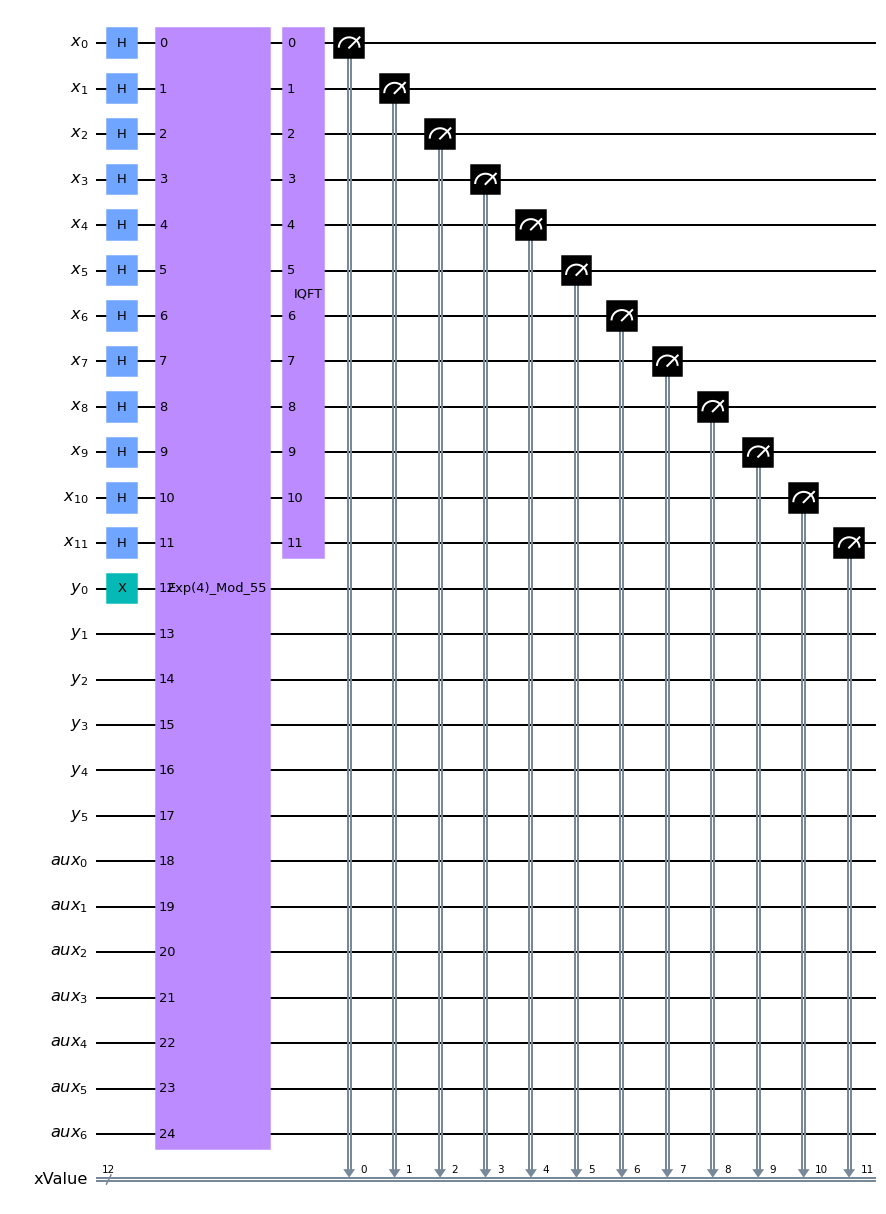

In [24]:
circuit = shor.construct_circuit(a, N, semi_classical=False, measurement=True)
circuit.draw(output='mpl', fold=-1)

Invoke `get_order()` to run algorithm and post-process measurements. Usage of IBMQ simulator for `n > 5` is suggested.
Setting `semi_classical` argument to `True` will run algorithm on optimized version of circuit.

In [25]:
result = shor.get_order(a, N, semi_classical=True)

account.job_final_status:INFO:2022-05-14 21:30:38,736: Error checking job status using websocket, retrying using HTTP: 'Failed to authenticate against the server: Traceback (most recent call last):\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_app.py", line 327, in run_forever\n    self.sock.connect(\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_core.py", line 248, in connect\n    self.handshake_response = handshake(self.sock, url, *addrs, **options)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 57, in handshake\n    status, resp = _get_resp_headers(sock)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 148, in _get_resp_headers\n    raise WebSocketBadStatusException("Handshake status %d %s", status, status_message, resp_headers)\nwebsocket._exceptions.WebSocketBadStatusException: Handshake status 502 Ba

implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 410.
implementations.shor: Measured phase = 0.10009765625.
implementations.shor: Fractional approximation: 1/10.
implementations.shor: Success, order: r = 10 from measurement 410.
implementations.shor: Measurement = 819.
implementations.shor: Measured phase = 0.199951171875.
implementations.shor: Fractional approximation: 1/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*5 = 10.
implementations.shor: Measurement = 1229.
implementations.shor: Measured phase = 0.300048828125.
implementations.shor: Fractional approximation: 3/10.
implementations.shor: Success, order: r = 10 from measurement 1229.
implementations.shor: Measurement = 1638.
implementations.shor: Measured phase = 0.39990234375.
implementations.shor: Fra

Print result. Compare it with earlier observed order.

In [26]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)

64 50
13 12
10


## Eva's algorithm

Use `get_order()` to perform tasks from laboratories.
For modular power and modular inverse see: https://docs.python.org/3.8/library/functions.html#pow|

In [27]:
N = 55
c = 17
d = 33

a = 9
b = pow(a, c, mod=N)
print(b)

4


In [28]:
circuit = shor.construct_circuit(b, N, semi_classical=False, measurement=True)
# circuit.draw(output='mpl', fold=-1)

In [29]:
result = shor.get_order(b, N, semi_classical=True)
r = result.order

account.job_final_status:INFO:2022-05-14 21:31:27,928: Error checking job status using websocket, retrying using HTTP: 'Failed to authenticate against the server: Traceback (most recent call last):\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_app.py", line 327, in run_forever\n    self.sock.connect(\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_core.py", line 248, in connect\n    self.handshake_response = handshake(self.sock, url, *addrs, **options)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 57, in handshake\n    status, resp = _get_resp_headers(sock)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 148, in _get_resp_headers\n    raise WebSocketBadStatusException("Handshake status %d %s", status, status_message, resp_headers)\nwebsocket._exceptions.WebSocketBadStatusException: Handshake status 502 Ba

implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 408.
implementations.shor: Measured phase = 0.099609375.
implementations.shor: Fractional approximation: 1/10.
implementations.shor: Success, order: r = 10 from measurement 408.
implementations.shor: Measurement = 409.
implementations.shor: Measured phase = 0.099853515625.
implementations.shor: Fractional approximation: 1/10.
implementations.shor: Success, order: r = 10 from measurement 409.
implementations.shor: Measurement = 410.
implementations.shor: Measured phase = 0.10009765625.
implementations.shor: Fractional approximation: 1/10.
implementations.shor: Success, order: r = 10 from measurement 410.
implementations.shor: Measurement = 819.
implementations.shor: Measured phase = 0.199951171875.
implementations.shor: Fractional approximation: 1/5.
implementations.shor: Denominator 5 is not the order. Trying multiplication for case when numerato

In [30]:
print(r)

10


In [31]:
d_p = pow(c, -1, mod=r)
print(d_p, c * d_p % r == 1)

3 True


In [32]:
a_eva = pow(b, d_p, mod=N)
print(a_eva, a_eva == a)

9 True


## Bob's algorithm

In [33]:
def gcd(x, y):
    while(y):
        x, y = y, x % y
    return x

In [34]:
gcd(55, 23)

1

In [35]:
def eva_algorithm(N, b):
    while True:
        print('-----------------------------')
        a = random.randrange(1, N)
        print(f'Random a: {a}')

        current_gcd = gcd(a, N)
        if current_gcd not in [1, N]:
            print(f'Wow! That was lucky! GCD is {current_gcd}')
            p = current_gcd
            q = N // p
            return p, q
    
        result = shor.get_order(a, N, semi_classical=True)
        r = result.order
        
        if r % 2 == 1:
            print(f'Found r={r}, but it is odd :(')
            continue
        
        print(f'Found r={r}. Uff... It is even')
        l = a ** (r // 2) - 1
        r = a ** (r // 2) + 1
        
        current_gcd = gcd(r, N)
        if current_gcd in [1, N]:
            print(f'Bad luck... GCD is {current_gcd}')
            continue
            
        print('Success!')
        p = current_gcd
        q = N // p
        return p, q

In [36]:
p, q = eva_algorithm(N, b)

-----------------------------
Random a: 37


account.job_final_status:INFO:2022-05-14 21:32:36,613: Error checking job status using websocket, retrying using HTTP: 'Failed to authenticate against the server: Traceback (most recent call last):\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_app.py", line 327, in run_forever\n    self.sock.connect(\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_core.py", line 248, in connect\n    self.handshake_response = handshake(self.sock, url, *addrs, **options)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 57, in handshake\n    status, resp = _get_resp_headers(sock)\n  File "C:\\Users\\MatiX\\anaconda3\\envs\\py310\\lib\\site-packages\\websocket\\_handshake.py", line 148, in _get_resp_headers\n    raise WebSocketBadStatusException("Handshake status %d %s", status, status_message, resp_headers)\nwebsocket._exceptions.WebSocketBadStatusException: Handshake status 502 Ba

implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 409.
implementations.shor: Measured phase = 0.099853515625.
implementations.shor: Fractional approximation: 1/10.
implementations.shor: Denominator 10 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*10 = 20.
implementations.shor: Measurement = 410.
implementations.shor: Measured phase = 0.10009765625.
implementations.shor: Fractional approximation: 1/10.
implementations.shor: Denominator 10 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*10 = 20.
implementations.shor: Measurement = 613.
implementations.shor: Measured phase = 0.149658203125.
implementations.shor: Fractional approximation: 3/20.
implementations.shor: Success, order: r = 20 from measurement 6

In [37]:
print(p, q)

5 11


In [38]:
G_order = (p - 1) * (q - 1)

In [39]:
d_bob = pow(c, -1, mod=G_order)
print(d_bob, c * d_bob % G_order == 1)

33 True


In [40]:
a_bob = pow(b, d, mod=N)
print(a_bob, a_bob == a)

9 True
